In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

In [ ]:
#userà dei metodi per trovare gli outlier ma non avendo la ground truth non ci saprà dire effettivamente se sono tali o meno

# Data Preparation

In [ ]:
df = pd.read_csv(r'C:\Users\Asia\Desktop\Università\Magistrale\Data Mining\Dm 2\Progetto\Dataset\datatraining.txt',skipinitialspace=True, na_values='?', keep_default_na=True)
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [ ]:
class_name = 'Occupancy'
columns2remove = ['date']
df.drop(columns2remove, inplace=True, axis=1)

In [ ]:
import sys
sys.path.append('./')

In [ ]:
from data_preparation import prepare_dataset

In [ ]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,23.18,27.2720,426.0,721.25,0.004793,1
2,23.15,27.2675,429.5,714.00,0.004783,1
3,23.15,27.2450,426.0,713.50,0.004779,1
4,23.15,27.2000,426.0,708.25,0.004772,1
5,23.10,27.2000,426.0,704.50,0.004757,1


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
columns = ['Temperature', 'Light', 'CO2', 'HumidityRatio', 'Humidity']
scaler.fit(np.array(df[columns]))
df[columns] = scaler.transform(np.array(df[columns]))

In [ ]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# Box Plot

In [ ]:
#il primo metodo visto in dm 1 è il box-plot, si tratta di un approccio visuale
# è un 1-dimensional technique per l'outlier detection

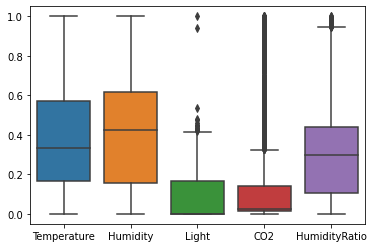

In [ ]:
sns.boxplot(data=[X[:,0], X[:,1], X[:,2], X[:,3], X[:,4]])
plt.xticks([0,1,2,3,4], [attributes[0], attributes[1], attributes[2], attributes[3], attributes[4]])
plt.show() # in questo caso i punti neri al di fuori del box-plot sono considerati outlier

In [ ]:
#per fare la stessa cosa, ma in forma numerica e non visuale, puoi calcolare il range interquartile considerando come outlier i punti che sono 1.5 volte distanti dall'upper e lower bound del box-plot

# DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
#con dbscan si considerano i noise point come outlier

In [ ]:
dbscan = DBSCAN(eps=0.3, min_samples=15)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=15, n_jobs=None, p=None)

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
dist = pdist(X, 'euclidean') #pair wise distance
print (dist)
dist = squareform(dist) #distance matrix given the vector dist
print()
print(dist)

[0.00911665 0.00941423 0.01259049 ... 0.01682489 0.01779259 0.00976864]

[[0.         0.00911665 0.00941423 ... 0.67083321 0.67843637 0.67621976]
 [0.00911665 0.         0.00270642 ... 0.66677218 0.6745385  0.67227128]
 [0.00941423 0.00270642 0.         ... 0.66773925 0.67552213 0.67328101]
 ...
 [0.67083321 0.66677218 0.66773925 ... 0.         0.01682489 0.01779259]
 [0.67843637 0.6745385  0.67552213 ... 0.01682489 0.         0.00976864]
 [0.67621976 0.67227128 0.67328101 ... 0.01779259 0.00976864 0.        ]]


In [ ]:
k = 20
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

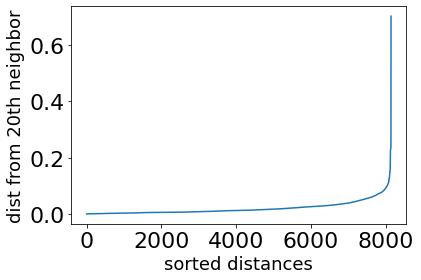

In [ ]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [ ]:
np.unique(dbscan.labels_, return_counts=True) 
#ottengo un grande cluster 0, e un altro con label -1, che rappresenta il cluster degli outlier, che contiene 3 outlier

(array([-1,  0], dtype=int64), array([   2, 8141], dtype=int64))

In [ ]:
from sklearn.metrics import silhouette_score
print('Silhouette %s' % silhouette_score(X, dbscan.labels_))

Silhouette 0.4451384134125777


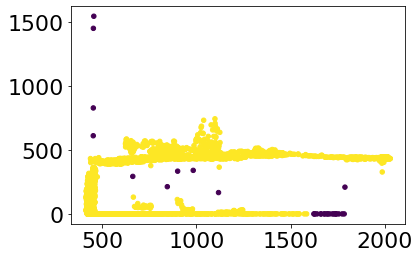

In [ ]:
plt.scatter(df['CO2'], df['Light'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [ ]:
df.index

RangeIndex(start=0, stop=8143, step=1)

In [ ]:
df.loc[np.where(dbscan.labels_== -1)]

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
3831,0.406699,0.095877,0.395452,0.024447,0.044872,0
3832,0.406699,0.095877,1.000000,0.026355,0.044872,0


# LOF

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

In [ ]:
clf = LocalOutlierFactor(n_neighbors=2)
outliers = clf.fit_predict(X) #ottengo la label 1 o -1 applicata al punto

negative_outlier_factor_

The opposite LOF of the training samples. The higher, the more normal. Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), while outliers tend to have a larger LOF score.

The local outlier factor (LOF) of a sample captures its supposed ‘degree of abnormality’. It is the average of the ratio of the local reachability density of a sample and those of its k-nearest neighbors.

In [ ]:
#questo è invece l'outlierness SCORE
clf.negative_outlier_factor_ #non abbiamo il LOF factor, ma il suo opposto, il negative outlier factor
#più è alto, vicino a -1, più è normale il punto, se invece è basso è più probabile che sia un outlier, VICINO A 1 OUTLIER

array([-1.65365739, -0.92969227, -1.16362344, ..., -2.35757908,
       -1.05941275, -1.05941275])

In [ ]:
np.unique(outliers, return_counts=True) #vediamo che 75 record sono stati classificati come outlier

(array([-1,  1]), array([1584, 6559], dtype=int64))

In [ ]:
np.where(outliers==-1) #di cui qui vediamo gli indici

(array([   0,    4,    8, ..., 8104, 8112, 8140], dtype=int64),)

In [ ]:
clf.negative_outlier_factor_[np.where(outliers==-1)] #mentre questi sono i valori corrispondenti dello score

array([-1.65365739, -3.20471517, -2.62650979, ..., -1.80462598,
       -1.50147775, -2.35757908])

In [ ]:
np.max(clf.negative_outlier_factor_[np.where(outliers==-1)]) #questo è l'outlier con il minimo score, con minore probabilità

-1.500835075222013

In [ ]:
#più è negativo lo score più è outlier
np.min(clf.negative_outlier_factor_[np.where(outliers==-1)]) #questo è l'outlier con il massimo score, con la maggiore probabilità

-67666714.89816085

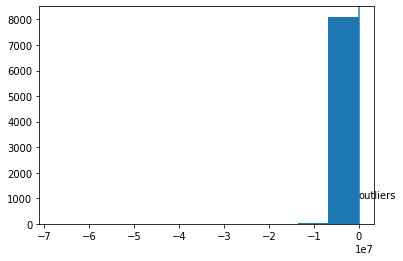

In [ ]:
#questa è la distribuzione del livello di outlierness
plt.hist(clf.negative_outlier_factor_)
plt.axvline(-4) # usiamo 1.5, il max del negative LOF come soglia
plt.text(-4, 1000, 'outliers') #la parte sinistra è quella degli outlier
plt.show()

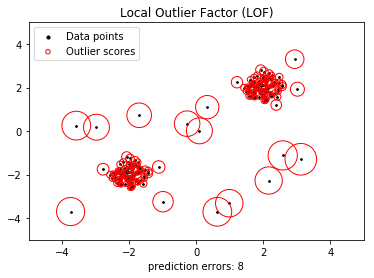

In [ ]:
np.random.seed(42)

# QUI IL MALEDETTO SI GENERA UN TRAINING SET!!! Lo genera in modo da sapere quali sono gli outlier e quali no, quindi per conoscere la ground truth

# Generate train data
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

# Generate some outliers
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2)) #nota che su 20 outlier fa 8 errori di predizione
Xa = np.r_[X_inliers, X_outliers]

n_outliers = len(X_outliers)
ground_truth = np.ones(len(Xa), dtype=int)
ground_truth[-n_outliers:] = -1

#DOPO la creazione, APPLICA il LOF con i parametri di default

# fit the model for outlier detection (default)
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1) 
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = clf.fit_predict(Xa)
n_errors = (y_pred != ground_truth).sum()
X_scores = clf.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(Xa[:, 0], Xa[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors)) #ERRORE DI PREDIZIONE basato sulla ground truth
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

#in nero ci sono i data point, e i cerchi indicano il livello di outlierness, più grande è il cerchio maggiore è il livello di outlierness
# nota che i punti all'interno dei due cluster hanno cerchi molto piccoli e concentrati, quindi non sono outlier

In [ ]:
#NON L'ABBIAMO STUDIATO, ma ESISTE e lui lo ha messo qui a caso!
from sklearn.ensemble import IsolationForest
# è un altro metodo per trovare outlier

In [ ]:
clf = IsolationForest(random_state=0)
clf.fit(X_train)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=0, verbose=0, warm_start=False)

In [ ]:
outliers = clf.predict(X_test)

In [ ]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([ 723, 1720], dtype=int64))

# PyOD

https://pyod.readthedocs.io/en/latest/#

In [ ]:
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.auto_encoder import AutoEncoder

## ABOD

In [ ]:
clf = ABOD(n_neighbors=20)
clf.fit(X)

ABOD(contamination=0.1, method='fast', n_neighbors=20)

In [ ]:
clf.decision_scores_ # è il livello di outlierness

array([ -2341280.23891037, -18322664.30893147, -18664150.4863077 , ...,
         -687178.09560201,    -94515.53583206,   -105610.23055153])

In [ ]:
outliers = clf.predict(X) # ottengo la label con predict
np.unique(outliers, return_counts=True) # 1 se outlier, 0 se normale

(array([0, 1]), array([7362,  781], dtype=int64))

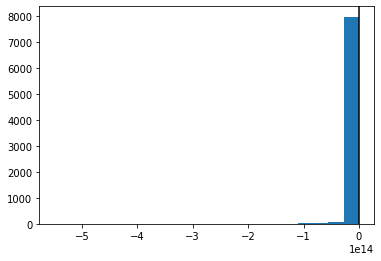

In [ ]:
plt.hist(clf.decision_scores_, bins=20)
plt.axvline(np.min(clf.decision_scores_[np.where(outliers==1)]), c='k')
plt.show()

## KNN

In [ ]:
#qui faccio il K-NN con k=5 di default
clf = KNN()
clf.fit(X)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

In [ ]:
clf.decision_scores_ #è basato sulla distanza in pratica

array([0.02517301, 0.01746289, 0.01600595, ..., 0.01779259, 0.0319463 ,
       0.03195306])

In [ ]:
anomlay_score = clf.decision_function(X)

In [ ]:
outliers = clf.predict(X) # label 0 se normale, 1 se outlier
np.unique(outliers, return_counts=True)

(array([0, 1]), array([7571,  572], dtype=int64))

In [ ]:
np.mean(anomlay_score[np.where(outliers==1)]) #con la funzione del decision score

0.029490970197550304

In [ ]:
np.mean(anomlay_score[np.where(outliers==0)])

0.0052443877619879386

In [ ]:
np.mean(clf.decision_scores_[np.where(outliers==1)]) #senza la funzione del decision score

0.032552910682440706

In [ ]:
np.mean(clf.decision_scores_[np.where(outliers==0)])

0.006126067324986832

## LOF

In [ ]:
# LOF di un altra libreria, funziona sempre allo stesso modo
clf = LOF()
clf.fit(X)

outliers = clf.predict(X)
np.unique(outliers, return_counts=True)

(array([0, 1]), array([7471,  672], dtype=int64))

# AutoEncoder

In [ ]:
clf = AutoEncoder(epochs=50, hidden_neurons =[5,8,8,5])
#utile per trovare outlier, perchè un reconstruction errore molto alto significa che il  punto che hai cercato di comprimere e decomprimere è molto lontano dai punti su cui l'autoencoder è stato allenato

In [ ]:
clf.fit(X_train)

outliers = clf.predict(X_train)
np.unique(outliers, return_counts=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 30        
_________________________________________________________________
dropout_3 (Dropout)          (None, 5)                 0         
_______________________________________

(array([0, 1]), array([5130,  570], dtype=int64))

In [ ]:
anomlay_score = clf.decision_function(X_train)

In [ ]:
outliers_proba = clf.predict_proba(X_train)

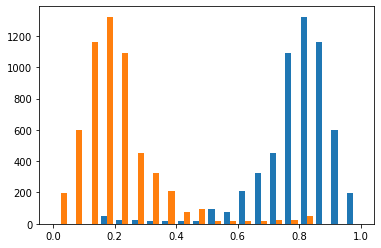

In [ ]:
plt.hist(outliers_proba, bins=20)
plt.axvline(np.min(anomlay_score[np.where(outliers==1)]), c='k')
plt.show()

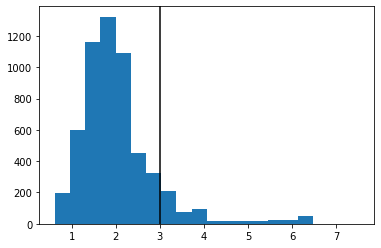

In [ ]:
plt.hist(anomlay_score, bins=20)
plt.axvline(np.min(anomlay_score[np.where(outliers==1)]), c='k')
plt.show()

In [ ]:
#ESEMPIO NOTEBOOOK!

%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


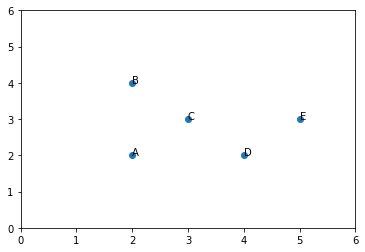

In [ ]:
D = np.array([
    [2, 2],
    [2, 4],
    [3, 3],
    [4, 2],
    [5, 3],
])


plt.scatter(D[:, 0], D[:, 1])
for d, l in zip(D, ['A', 'B', 'C', 'D', 'E']):
    plt.text(d[0], d[1], l)
plt.xlim([0, 6])
plt.ylim([0, 6])
plt.show()

In [ ]:
from scipy.spatial.distance import pdist, squareform

In [ ]:
dist = squareform(pdist(D, 'cityblock'))
for i in range(len(dist)):
    dist[i, i] = np.inf
dist

array([[inf,  2.,  2.,  2.,  4.],
       [ 2., inf,  2.,  4.,  4.],
       [ 2.,  2., inf,  2.,  2.],
       [ 2.,  4.,  2., inf,  2.],
       [ 4.,  4.,  2.,  2., inf]])

In [ ]:
k = 3
knn = np.argsort(dist, axis=1)[:, :k]
knn

array([[1, 2, 3],
       [0, 2, 3],
       [0, 1, 3],
       [0, 2, 4],
       [2, 3, 0]])

In [ ]:
Rknn = np.zeros((len(dist), len(dist)))
for i in range(len(dist)):
    for j in knn[i]:
        Rknn[j][i] = 1
Rknn

array([[0., 1., 1., 1., 1.],
       [1., 0., 1., 0., 0.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 0., 1.],
       [0., 0., 0., 1., 0.]])

In [ ]:
Rknn_count = np.sum(Rknn, axis=1)
Rknn_count.reshape(-1,1)

array([[4.],
       [2.],
       [4.],
       [4.],
       [1.]])